# Retinotopy visualization across optic lobe neuropiles

In [281]:
## Getting Mi1 positions (terminals)

## RUN ONLY ONCE



# Getting pre-synaptic sites
terminal_position_ls = []
curr_id_ls = df_grid.root_id.tolist()


# output_df = flywire.synapses.get_synapses(curr_id_ls, pre=True, post=False, attach=True, 
#                                              min_score=50, clean=True, transmitters=False, 
#                                              neuropils=True, batch_size=30, 
#                                              dataset='production', progress=True)

# # Saving the output_df file in a csv file

# fileName = 'C2_pre_sites.csv'
# savingPath = os.path.join(dataPath,'from_FAFBseg-py',fileName)
# # saving the dataframe
# output_df.to_csv(savingPath, index=False)



input_df = flywire.synapses.get_synapses(curr_id_ls, pre=False, post=True, attach=True, 
                                             min_score=50, clean=True, transmitters=False, 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True)

# Saving the output_df file in a csv file

fileName = 'L3_post_sites.csv'
savingPath = os.path.join(dataPath,'from_FAFBseg-py',fileName)
# saving the dataframe
input_df.to_csv(savingPath, index=False)




Using materialization version 783.


Fetching synapses:   0%|          | 0/25 [00:00<?, ?it/s]

In [188]:
# Importing some packages
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import math
import numpy as np
import pandas as pd
import seaborn as sns
import os
from fafbseg import flywire
from helper import combine_xyz

In [189]:
# Importing data from Codex
dataPath = R'D:\Connectomics-Data\FlyWire\Codex-datasets'
fileName = 'ol_columns.csv.gz'
filePath = os.path.join(dataPath,fileName)
columns_id_data = pd.read_csv(filePath, compression='gzip')
columns_id_data.rename(columns={"cell id": "root_id","cell type": "cell_type","column id": "column_id" }, inplace= True)

dataPath = R'D:\Connectomics-Data\FlyWire\Codex-datasets'
fileName = 'column_assignment.csv.gz'
filePath = os.path.join(dataPath,fileName)
columns_id_coordinates = pd.read_csv(filePath, compression='gzip')

## 1. Getting reliable xyz column coordinates and reference lines in different neuropiles and layers

Add brief description of the following lines

### 1.1 Lamina

In [324]:
# Some user parameters
cell_for_grid = 'L3'
sites = 'post'

In [325]:
# Looking deeply at the match between individual cells and individual columns
cells_columns = columns_id_data[columns_id_data['cell_type'] == cell_for_grid]
number_unique_cells = len(cells_columns['root_id'].unique())
if 'not assigned' in cells_columns['column_id'].unique():
    number_unique_columns = len(cells_columns['column_id'].unique())-1 #-1 to compensate for "not assigned label" of some cells
else:
    number_unique_columns = len(cells_columns['column_id'].unique())
    

print(f'Total number of unique cells: {number_unique_cells}')
print(f'Total number of unique columns: {number_unique_columns}')
print(f'Missmatch: {number_unique_cells - number_unique_columns}')

# Identify duplicate values in 'column id'
duplicates = cells_columns[cells_columns.duplicated('column_id', keep=False)]

print(f'Number of duplicates / cells not assigned to columns: {len(duplicates)}')

# Filter out rows with repetitive values
filtered_cells_columns = cells_columns[~cells_columns['column_id'].isin(duplicates['column_id'])]
print(f'Filtered data length: {len(filtered_cells_columns)}')

# Addining column coordinates information
df_grid =  pd.merge(filtered_cells_columns, columns_id_coordinates[['root_id', 'p', 'q', 'x', 'y']], on='root_id', how='left')
print(f'Final df_grid length: {len(df_grid)}')
display(df_grid.head())

Total number of unique cells: 737
Total number of unique columns: 729
Missmatch: 8
Number of duplicates / cells not assigned to columns: 8
Filtered data length: 729
Final df_grid length: 729


,root_id,cell_type,column_id,p,q,x,y
0,720575940604889568,L3,580,-10,-13,2,-23
1,720575940605268140,L3,197,-10,-10,0,-20
2,720575940605273772,L3,194,-3,-2,0,-5
3,720575940605345410,L3,614,-2,-6,2,-8
4,720575940605432492,L3,779,7,17,-5,24


In [326]:
df_grid[df_grid.root_id == 720575940620910612]

,root_id,cell_type,column_id,p,q,x,y
228,720575940620910612,L3,181,-3,-1,-1,-4


In [327]:
#Loading the data from the csv file
fileName = f'{cell_for_grid}_{sites}_sites.csv'
savingPath = os.path.join(dataPath,'from_FAFBseg-py',fileName)
syn_sites_df = pd.read_csv(savingPath)
combine_xyz(syn_sites_df)

In [328]:
## Filtra per neuropil
_neuropile = 'LA_R'
syn_sites_df = syn_sites_df[syn_sites_df.neuropil == _neuropile].copy()

## Filter per syn_pt_root_id ids that do not have enough data for PCA
#Count occurrences of each syn_pt_root_id
counts = syn_sites_df[f'{sites}_pt_root_id'].value_counts()

#Filter rows where syn_pt_root_id appears at least 3 times
syn_sites_df = syn_sites_df[syn_sites_df[f'{sites}_pt_root_id'].isin(counts[counts >= 3].index)].copy()

#Print the number of unique ids that were discarded
discarded_ids = counts[counts < 3]
print(f"Number of unique syn_pt_root_id discarded: {len(discarded_ids)}")



Number of unique syn_pt_root_id discarded: 0


In [329]:
# PCA to get the depth axis of each L1
# Selecting single neuron / column
single_column_id = '181' # is a string good examples: 91, 416, 181
single_point_id  = df_grid[df_grid.column_id== single_column_id].root_id.tolist()[0]
centroid_ls = []
root_id_ls =[]
centroid_x_ls = []
centroid_y_ls = []
centroid_z_ls = []

single_point_x_ls = []
single_point_y_ls = []
single_point_z_ls = []

for root_id in syn_sites_df[f'{sites}_pt_root_id'].unique():
    # Getting single L1 post synaptic sites
    curr_df = syn_sites_df[syn_sites_df[f'{sites}_pt_root_id'] == int(root_id)]
    temp_positions_syn_syn = np.array(curr_df[f'{sites}_pt_position'].values)
    # Convert list of lists to a 2D NumPy array
    positions_syn_syn = np.array([np.array(lst) for lst in temp_positions_syn_syn])
    
    #Doing PCA
    from sklearn.decomposition import PCA
    pca = PCA(n_components=3)  # Reduce to 3 components (since we have 3D data)
    pca_result = pca.fit_transform(positions_syn_syn)
    
    
    pc1 = pca_result[:, 0] # Get the PC1 axis (1st principal component)
    sorted_indices = np.argsort(pc1) # Sort points based on their PC1 values
    # if root_id in [720575940626852201,720575940632527524]:
    #     sorted_indices = np.argsort(pc1)[::-1] # Hard coding PC1 axis for two ids, descending order
        
    num_points = len(pc1) # Select the top 10% from the end 
    bottom_10_percent_idx = sorted_indices[-int(1 * num_points):]  # Take all 100% 
    bottom_10_percent_points = positions_syn_syn[bottom_10_percent_idx] # Get the original points corresponding to the top 10% in PC1
    
    #Calculating the centroid of those points (center of mass)
    centroid = bottom_10_percent_points.mean(axis=0) # Calculate the center of mass by taking the mean of each coordinate (x, y, z)
    centroid_ls.append(centroid)
    root_id_ls.append(root_id)
    centroid_x_ls.append(centroid[0]*4)
    centroid_y_ls.append(centroid[1]*4)
    centroid_z_ls.append(centroid[2]*40)
    if root_id == single_point_id:
        single_point_x_ls.append(centroid[0]*4)
        single_point_y_ls.append(centroid[1]*4)
        single_point_z_ls.append(centroid[2]*40)
        
        

centroids_df = pd.DataFrame({'centroid_M10':centroid_ls,'centroid_x':centroid_x_ls,'centroid_y':centroid_y_ls,'centroid_z':centroid_z_ls, 'root_id':root_id_ls})
# Merge to add from_cell_type
df_grid_extended = centroids_df.merge(
    df_grid,
    how='left',
    left_on='root_id',
    right_on='root_id'
)

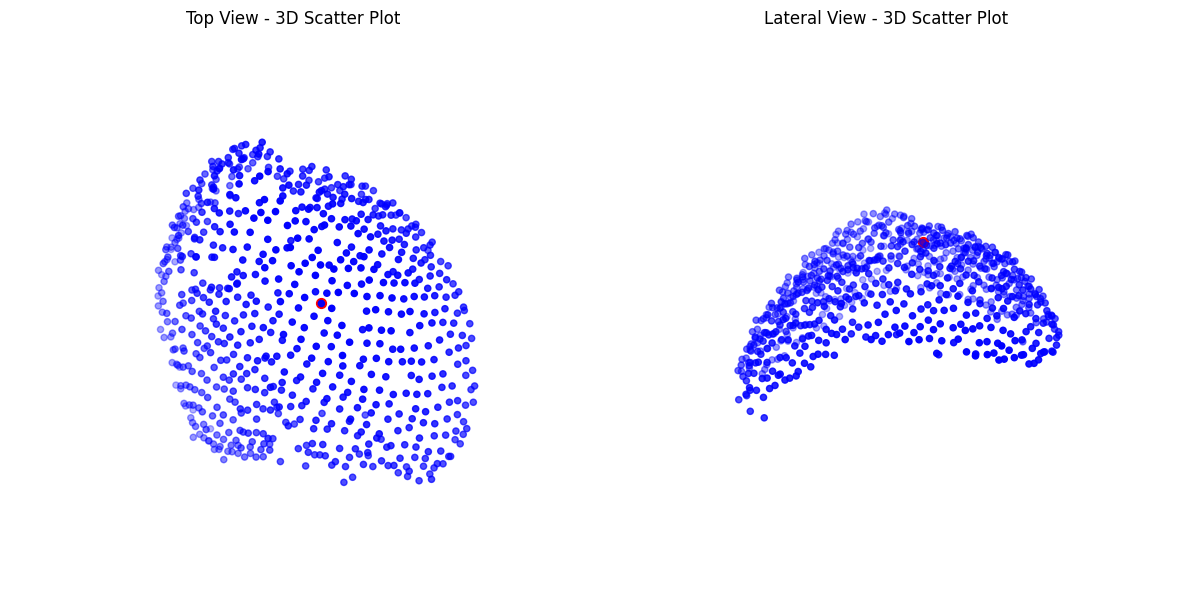

In [330]:
## Looking at the extracted centroids with respect to the medulla

import navis
import matplotlib.pyplot as plt



# Viewing angles for top view and lateral view
top_view_azim = 16
top_view_elev = -50
lateral_view_azim = 4
lateral_view_elev = -130

# Data 
x = centroid_x_ls
y = centroid_y_ls
z = centroid_z_ls

# Single point
single_x = single_point_x_ls
single_y = single_point_y_ls
single_z = single_point_z_ls


# Create a figure with 1 row and 2 columns for subplots
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(12, 6))



# First subplot: Top view
ax1.azim = top_view_azim
ax1.elev = top_view_elev
ax1.scatter(x, y, z, c='b', marker='o')
ax1.scatter(single_x, single_y, single_z, c='r', marker='o', s=50)

#ax1.set_xlabel('X Position')
#ax1.set_ylabel('Y Position')
#ax1.set_zlabel('Z Position')
ax1.set_axis_off()
ax1.set_title('Top View - 3D Scatter Plot')

# Second subplot: Lateral view
ax2.azim = lateral_view_azim
ax2.elev = lateral_view_elev
ax2.scatter(x, y, z, c='b', marker='o')
ax2.scatter(single_x, single_y, single_z, c='r', marker='o', s=50)
#ax2.set_xlabel('X Position')
#ax2.set_ylabel('Y Position')
#ax2.set_zlabel('Z Position')
ax2.set_axis_off()
ax2.set_title('Lateral View - 3D Scatter Plot')

# Display the plot
plt.tight_layout()
plt.show()

In [331]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objects as go

# Initialize the Dash app
app = dash.Dash(__name__)

# Create a Plotly figure
fig = go.Figure()

# Add all points in black with hover info
fig.add_trace(go.Scatter3d(
    x=centroid_x_ls,
    y=centroid_y_ls,
    z=centroid_z_ls,
    mode='markers',
    marker=dict(size=4, color='black'),
    name='Centroids',
    text=root_id_ls,  # List of IDs to show on hover
    hoverinfo='text',  # Only show text on hover
    customdata=root_id_ls,  # Include IDs as custom data
))

fig.add_trace(go.Scatter3d(
    x=single_point_x_ls,
    y=single_point_y_ls,
    z=single_point_z_ls,
    mode='markers',
    marker=dict(size=8, color='red'),
    name='Single point',
    text=root_id_ls,  # List of IDs to show on hover
    hoverinfo='text',  # Only show text on hover
    customdata=root_id_ls,  # Include IDs as custom data
))

# Set axis off
fig.update_layout(
    scene=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False)
    )
)

# Layout for the Dash app
app.layout = html.Div([
    dcc.Graph(
        id='3d-scatter-plot',
        figure=fig
    ),
    html.Div(id='click-data', style={'margin-top': '20px'})  # Div to show clicked ID
])

# Callback to handle clicks on the plot
@app.callback(
    Output('click-data', 'children'),
    Input('3d-scatter-plot', 'clickData')
)
def display_click_data(clickData):
    if clickData is None:
        return "Click on a point to see the ID."
    else:
        # Extract the ID from the custom data
        clicked_id = clickData['points'][0]['customdata']
        return f'Clicked ID: {clicked_id}'

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

### 1.2 Upper medulla

In [308]:
# Some user parameters
cell_for_grid = 'Mi1'
sites = 'pre'

In [309]:
# Looking deeply at the match between individual cells and individual columns
cells_columns = columns_id_data[columns_id_data['cell_type'] == cell_for_grid]
number_unique_cells = len(cells_columns['root_id'].unique())
if 'not assigned' in cells_columns['column_id'].unique():
    number_unique_columns = len(cells_columns['column_id'].unique())-1 #-1 to compensate for "not assigned label" of some cells
else:
    number_unique_columns = len(cells_columns['column_id'].unique())
    

print(f'Total number of unique cells: {number_unique_cells}')
print(f'Total number of unique columns: {number_unique_columns}')
print(f'Missmatch: {number_unique_cells - number_unique_columns}')

# Identify duplicate values in 'column id'
duplicates = cells_columns[cells_columns.duplicated('column_id', keep=False)]

print(f'Number of duplicates / cells not assigned to columns: {len(duplicates)}')

# Filter out rows with repetitive values
filtered_cells_columns = cells_columns[~cells_columns['column_id'].isin(duplicates['column_id'])]
print(f'Filtered data length: {len(filtered_cells_columns)}')

# Addining column coordinates information
df_grid =  pd.merge(filtered_cells_columns, columns_id_coordinates[['root_id', 'p', 'q', 'x', 'y']], on='root_id', how='left')
print(f'Final df_grid length: {len(df_grid)}')
display(df_grid.head())

Total number of unique cells: 796
Total number of unique columns: 796
Missmatch: 0
Number of duplicates / cells not assigned to columns: 0
Filtered data length: 796
Final df_grid length: 796


,root_id,cell_type,column_id,p,q,x,y
0,720575940603042272,Mi1,1,12,1,6,13
1,720575940603200428,Mi1,2,9,-7,8,2
2,720575940603327916,Mi1,3,-12,0,-6,-12
3,720575940603935334,Mi1,4,-6,-15,5,-21
4,720575940604151008,Mi1,6,0,-4,2,-4


In [310]:
df_grid[df_grid.root_id == 720575940611884773].column_id[89]

'91'

In [311]:
#Loading the data from the csv file
fileName = f'{cell_for_grid}_{sites}_sites.csv'
savingPath = os.path.join(dataPath,'from_FAFBseg-py',fileName)
pre_sites_df = pd.read_csv(savingPath)
combine_xyz(pre_sites_df)

In [312]:
# PCA to get the depth axis of each Mi1

# Selecting single neuron / column
single_column_id = '181' # is a string good examples: 91, 416, 181
single_point_id  = df_grid[df_grid.column_id== single_column_id].root_id.tolist()[0]

centroid_ls = []
root_id_ls =[]
centroid_x_ls = []
centroid_y_ls = []
centroid_z_ls = []

single_point_x_ls = []
single_point_y_ls = []
single_point_z_ls = []

for root_id in pre_sites_df.pre_pt_root_id.unique():
    # Getting single Mi1 pre synaptic sites
    curr_df = pre_sites_df[pre_sites_df.pre_pt_root_id == int(root_id)]
    temp_positions_pre_syn = np.array(curr_df.pre_pt_position.values)
    # Convert list of lists to a 2D NumPy array
    positions_pre_syn = np.array([np.array(lst) for lst in temp_positions_pre_syn])
    
    #Doing PCA
    from sklearn.decomposition import PCA
    pca = PCA(n_components=3)  # Reduce to 3 components (since we have 3D data)
    pca_result = pca.fit_transform(positions_pre_syn)
    
    
    pc1 = pca_result[:, 0] # Get the PC1 axis (1st principal component)
    sorted_indices = np.argsort(pc1) # Sort points based on their PC1 values
    if root_id in [720575940626852201,720575940632527524]:
        sorted_indices = np.argsort(pc1)[::-1] # Hard coding PC1 axis for two ids, descending order
        
    num_points = len(pc1) # Select the top 10% from the end 
    bottom_10_percent_idx = sorted_indices[-int(0.1 * num_points):]  # Take the last 10%  
    bottom_10_percent_points = positions_pre_syn[bottom_10_percent_idx] # Get the original points corresponding to the top 10% in PC1
    
    #Calculating the centroid of those points (center of mass)
    centroid = bottom_10_percent_points.mean(axis=0) # Calculate the center of mass by taking the mean of each coordinate (x, y, z)
    centroid_ls.append(centroid)
    root_id_ls.append(root_id)
    centroid_x_ls.append(centroid[0]*4)
    centroid_y_ls.append(centroid[1]*4)
    centroid_z_ls.append(centroid[2]*40)
    if root_id == single_point_id:
        single_point_x_ls.append(centroid[0]*4)
        single_point_y_ls.append(centroid[1]*4)
        single_point_z_ls.append(centroid[2]*40)
        
        

centroids_df = pd.DataFrame({'centroid_M10':centroid_ls,'centroid_x':centroid_x_ls,'centroid_y':centroid_y_ls,'centroid_z':centroid_z_ls, 'root_id':root_id_ls})
# Merge to add from_cell_type
df_grid_extended = centroids_df.merge(
    df_grid,
    how='left',
    left_on='root_id',
    right_on='root_id'
)

In [313]:
single_point_x_ls

[815881.281553398]

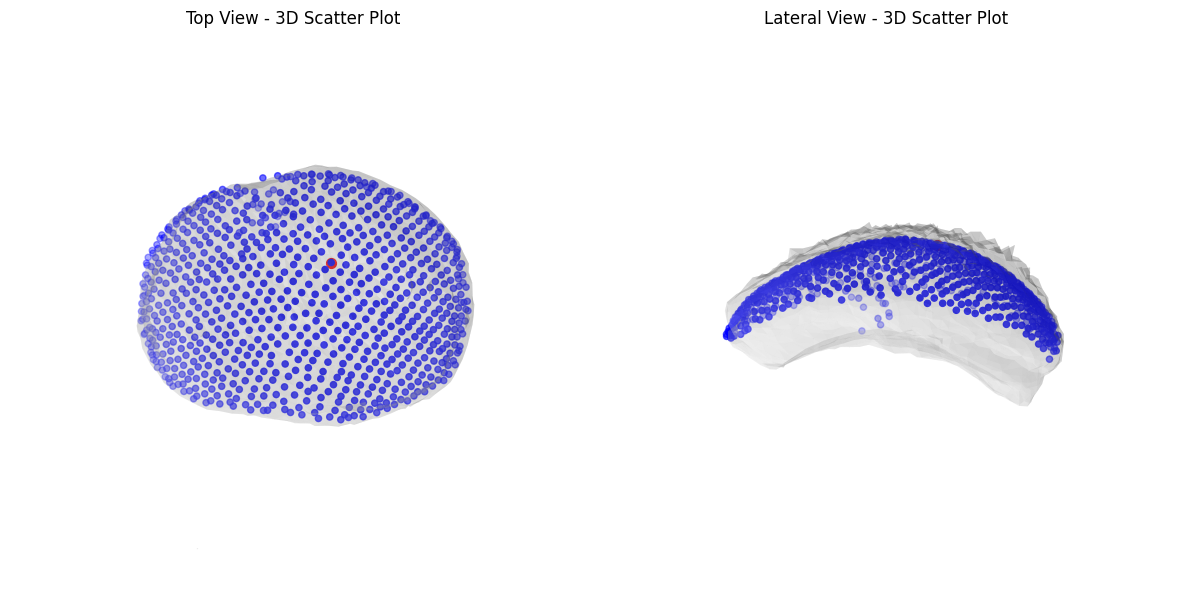

In [314]:
## Looking at the extracted centroids with respect to the medulla

import navis
import matplotlib.pyplot as plt

neurpile_mesh = 'ME_L'

# Viewing angles for top view and lateral view
top_view_azim = 16
top_view_elev = -50
lateral_view_azim = 4
lateral_view_elev = -130

# Data 
x = centroid_x_ls
y = centroid_y_ls
z = centroid_z_ls

# Single point
single_x = single_point_x_ls
single_y = single_point_y_ls
single_z = single_point_z_ls


# Create a figure with 1 row and 2 columns for subplots
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(12, 6))

# Get the mesh data
OL_R = flywire.get_neuropil_volumes([neurpile_mesh])

# First subplot: Top view
navis.plot2d([OL_R], method='3d_complex', ax=ax1, scalebar='20 um')
ax1.azim = top_view_azim
ax1.elev = top_view_elev
ax1.scatter(x, y, z, c='b', marker='o')
ax1.scatter(single_x, single_y, single_z, c='r', marker='o', s=50)

#ax1.set_xlabel('X Position')
#ax1.set_ylabel('Y Position')
#ax1.set_zlabel('Z Position')
ax1.set_axis_off()
ax1.set_title('Top View - 3D Scatter Plot')

# Second subplot: Lateral view
navis.plot2d([OL_R], method='3d_complex', ax=ax2, scalebar='20 um')
ax2.azim = lateral_view_azim
ax2.elev = lateral_view_elev
ax2.scatter(x, y, z, c='b', marker='o')
ax2.scatter(single_x, single_y, single_z, c='r', marker='o', s=50)
#ax2.set_xlabel('X Position')
#ax2.set_ylabel('Y Position')
#ax2.set_zlabel('Z Position')
ax2.set_axis_off()
ax2.set_title('Lateral View - 3D Scatter Plot')

# Display the plot
plt.tight_layout()
plt.show()

In [315]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objects as go

# Initialize the Dash app
app = dash.Dash(__name__)

# Create a Plotly figure
fig = go.Figure()

# Add all points in black with hover info
fig.add_trace(go.Scatter3d(
    x=centroid_x_ls,
    y=centroid_y_ls,
    z=centroid_z_ls,
    mode='markers',
    marker=dict(size=4, color='black'),
    name='Centroids',
    text=root_id_ls,  # List of IDs to show on hover
    hoverinfo='text',  # Only show text on hover
    customdata=root_id_ls,  # Include IDs as custom data
))

fig.add_trace(go.Scatter3d(
    x=single_point_x_ls,
    y=single_point_y_ls,
    z=single_point_z_ls,
    mode='markers',
    marker=dict(size=8, color='red'),
    name='Single point',
    text=root_id_ls,  # List of IDs to show on hover
    hoverinfo='text',  # Only show text on hover
    customdata=root_id_ls,  # Include IDs as custom data
))

# Set axis off
fig.update_layout(
    scene=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False)
    )
)

# Layout for the Dash app
app.layout = html.Div([
    dcc.Graph(
        id='3d-scatter-plot',
        figure=fig
    ),
    html.Div(id='click-data', style={'margin-top': '20px'})  # Div to show clicked ID
])

# Callback to handle clicks on the plot
@app.callback(
    Output('click-data', 'children'),
    Input('3d-scatter-plot', 'clickData')
)
def display_click_data(clickData):
    if clickData is None:
        return "Click on a point to see the ID."
    else:
        # Extract the ID from the custom data
        clicked_id = clickData['points'][0]['customdata']
        return f'Clicked ID: {clicked_id}'

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

### 1.3 Lower medulla

In [332]:
# Some user parameters
cell_for_grid = 'Mi1'
sites = 'pre'

In [333]:
# Looking deeply at the match between individual cells and individual columns
cells_columns = columns_id_data[columns_id_data['cell_type'] == cell_for_grid]
number_unique_cells = len(cells_columns['root_id'].unique())
if 'not assigned' in cells_columns['column_id'].unique():
    number_unique_columns = len(cells_columns['column_id'].unique())-1 #-1 to compensate for "not assigned label" of some cells
else:
    number_unique_columns = len(cells_columns['column_id'].unique())
    

print(f'Total number of unique cells: {number_unique_cells}')
print(f'Total number of unique columns: {number_unique_columns}')
print(f'Missmatch: {number_unique_cells - number_unique_columns}')

# Identify duplicate values in 'column id'
duplicates = cells_columns[cells_columns.duplicated('column_id', keep=False)]

print(f'Number of duplicates / cells not assigned to columns: {len(duplicates)}')

# Filter out rows with repetitive values
filtered_cells_columns = cells_columns[~cells_columns['column_id'].isin(duplicates['column_id'])]
print(f'Filtered data length: {len(filtered_cells_columns)}')

# Addining column coordinates information
df_grid =  pd.merge(filtered_cells_columns, columns_id_coordinates[['root_id', 'p', 'q', 'x', 'y']], on='root_id', how='left')
print(f'Final df_grid length: {len(df_grid)}')
display(df_grid.head())

Total number of unique cells: 796
Total number of unique columns: 796
Missmatch: 0
Number of duplicates / cells not assigned to columns: 0
Filtered data length: 796
Final df_grid length: 796


,root_id,cell_type,column_id,p,q,x,y
0,720575940603042272,Mi1,1,12,1,6,13
1,720575940603200428,Mi1,2,9,-7,8,2
2,720575940603327916,Mi1,3,-12,0,-6,-12
3,720575940603935334,Mi1,4,-6,-15,5,-21
4,720575940604151008,Mi1,6,0,-4,2,-4


In [334]:
#Loading the data from the csv file
fileName = f'{cell_for_grid}_{sites}_sites.csv'
savingPath = os.path.join(dataPath,'from_FAFBseg-py',fileName)
pre_sites_df = pd.read_csv(savingPath)
combine_xyz(pre_sites_df)

In [335]:
# PCA to get the depth axis of each Mi1

# Selecting single neuron / column
single_column_id = '181' # is a string good examples: 91, 416, 181
single_point_id  = df_grid[df_grid.column_id== single_column_id].root_id.tolist()[0]


centroid_ls = []
root_id_ls =[]
centroid_x_ls = []
centroid_y_ls = []
centroid_z_ls = []

single_point_x_ls = []
single_point_y_ls = []
single_point_z_ls = []

for root_id in pre_sites_df.pre_pt_root_id.unique():
    # Getting single Mi1 pre synaptic sites
    curr_df = pre_sites_df[pre_sites_df.pre_pt_root_id == int(root_id)]
    temp_positions_pre_syn = np.array(curr_df.pre_pt_position.values)
    # Convert list of lists to a 2D NumPy array
    positions_pre_syn = np.array([np.array(lst) for lst in temp_positions_pre_syn])
    
    #Doing PCA
    from sklearn.decomposition import PCA
    pca = PCA(n_components=3)  # Reduce to 3 components (since we have 3D data)
    pca_result = pca.fit_transform(positions_pre_syn)
    
    
    pc1 = pca_result[:, 0] # Get the PC1 axis (1st principal component)
    sorted_indices = np.argsort(pc1)[::-1]  # Sort points based on their PC1 values, descending order
    if root_id in [720575940626852201,720575940632527524]:
        sorted_indices = np.argsort(pc1) # Hard coding PC1 axis for two ids.
        
    num_points = len(pc1) # Select the top 10% from the end 
    bottom_10_percent_idx = sorted_indices[-int(0.1 * num_points):]  # Take the last 10%  
    bottom_10_percent_points = positions_pre_syn[bottom_10_percent_idx] # Get the original points corresponding to the top 10% in PC1
    
    #Calculating the centroid of those points (center of mass)
    centroid = bottom_10_percent_points.mean(axis=0) # Calculate the center of mass by taking the mean of each coordinate (x, y, z)
    centroid_ls.append(centroid)
    root_id_ls.append(root_id)
    centroid_x_ls.append(centroid[0]*4)
    centroid_y_ls.append(centroid[1]*4)
    centroid_z_ls.append(centroid[2]*40)
    if root_id == single_point_id:
        single_point_x_ls.append(centroid[0]*4)
        single_point_y_ls.append(centroid[1]*4)
        single_point_z_ls.append(centroid[2]*40)

centroids_df = pd.DataFrame({'centroid_M10':centroid_ls,'centroid_x':centroid_x_ls,'centroid_y':centroid_y_ls,'centroid_z':centroid_z_ls, 'root_id':root_id_ls})
# Merge to add from_cell_type
df_grid_extended = centroids_df.merge(
    df_grid,
    how='left',
    left_on='root_id',
    right_on='root_id'
)

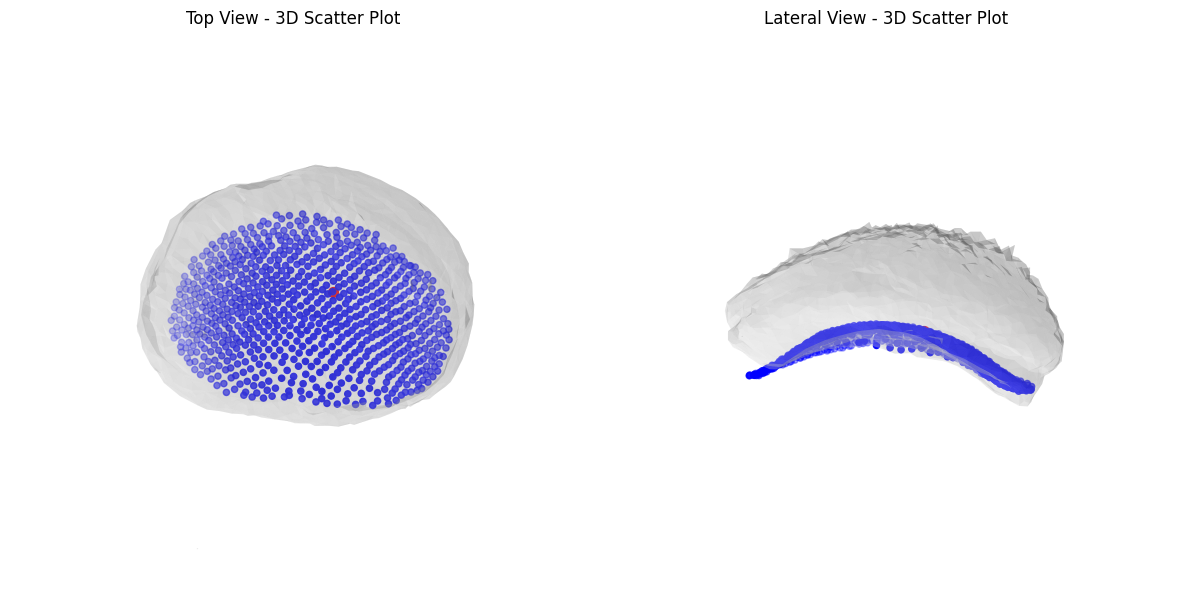

In [336]:
## Looking at the extracted centroids with respect to the medulla

import navis
import matplotlib.pyplot as plt

neurpile_mesh = 'ME_L'

# Viewing angles for top view and lateral view
top_view_azim = 16
top_view_elev = -50
lateral_view_azim = 4
lateral_view_elev = -130

# Data
x = centroid_x_ls
y = centroid_y_ls
z = centroid_z_ls

# Single point
single_x = single_point_x_ls
single_y = single_point_y_ls
single_z = single_point_z_ls


# Create a figure with 1 row and 2 columns for subplots
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(12, 6))

# Get the mesh data
OL_R = flywire.get_neuropil_volumes([neurpile_mesh])

# First subplot: Top view
navis.plot2d([OL_R], method='3d_complex', ax=ax1, scalebar='20 um')
ax1.azim = top_view_azim
ax1.elev = top_view_elev
ax1.scatter(x, y, z, c='b', marker='o')
ax1.scatter(single_x, single_y, single_z, c='r', marker='o', s=50)

#ax1.set_xlabel('X Position')
#ax1.set_ylabel('Y Position')
#ax1.set_zlabel('Z Position')
ax1.set_axis_off()
ax1.set_title('Top View - 3D Scatter Plot')

# Second subplot: Lateral view
navis.plot2d([OL_R], method='3d_complex', ax=ax2, scalebar='20 um')
ax2.azim = lateral_view_azim
ax2.elev = lateral_view_elev
ax2.scatter(x, y, z, c='b', marker='o')
ax2.scatter(single_x, single_y, single_z, c='r', marker='o', s=50)
#ax2.set_xlabel('X Position')
#ax2.set_ylabel('Y Position')
#ax2.set_zlabel('Z Position')
ax2.set_axis_off()
ax2.set_title('Lateral View - 3D Scatter Plot')

# Display the plot
plt.tight_layout()
plt.show()

In [337]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objects as go

# Initialize the Dash app
app = dash.Dash(__name__)

# Create a Plotly figure
fig = go.Figure()

# Add all points in black with hover info
fig.add_trace(go.Scatter3d(
    x=centroid_x_ls,
    y=centroid_y_ls,
    z=centroid_z_ls,
    mode='markers',
    marker=dict(size=4, color='black'),
    name='Centroids',
    text=root_id_ls,  # List of IDs to show on hover
    hoverinfo='text',  # Only show text on hover
    customdata=root_id_ls,  # Include IDs as custom data
))

fig.add_trace(go.Scatter3d(
    x=single_point_x_ls,
    y=single_point_y_ls,
    z=single_point_z_ls,
    mode='markers',
    marker=dict(size=8, color='red'),
    name='Single point',
    text=root_id_ls,  # List of IDs to show on hover
    hoverinfo='text',  # Only show text on hover
    customdata=root_id_ls,  # Include IDs as custom data
))

# Set axis off
fig.update_layout(
    scene=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False)
    )
)

# Layout for the Dash app
app.layout = html.Div([
    dcc.Graph(
        id='3d-scatter-plot',
        figure=fig
    ),
    html.Div(id='click-data', style={'margin-top': '20px'})  # Div to show clicked ID
])

# Callback to handle clicks on the plot
@app.callback(
    Output('click-data', 'children'),
    Input('3d-scatter-plot', 'clickData')
)
def display_click_data(clickData):
    if clickData is None:
        return "Click on a point to see the ID."
    else:
        # Extract the ID from the custom data
        clicked_id = clickData['points'][0]['customdata']
        return f'Clicked ID: {clicked_id}'

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)